In [ ]:
from __future__ import division
import networkx as nx
from networkx.algorithms.connectivity import local_edge_connectivity
import subprocess
import os
import matlab.engine
from collections import defaultdict
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import math
from gensim.models import Word2Vec
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from scipy import sparse
from scipy.stats import ttest_ind
from scipy.linalg import pinv
from scipy.linalg import sqrtm
from scipy.linalg import eig
from sklearn.metrics import mean_squared_error
from math import sqrt, log
from scipy.sparse.linalg import svds, eigs
import scipy.io
import time

In [ ]:
# HELPER FUNCTIONS
def effResRoutine(graph_file):
    
    eng = matlab.engine.start_matlab()
    er, E = eng.helperFunction( graph_file, nargout=2 )
    eng.quit()
    return np.array(er), np.array(E).astype(int)-1

def deleteFiles( fname ):
    if os.path.exists( fname ):
        os.remove( fname )
        
    return

def executeMace( inputFname, k):
    """
        inputFname (string) : input filename
        k (int) : k-clique parameter
        Returns:
        outputFilename (string)
    """
    cmd = "mace22/mace C -l "+str(k)+" "+inputFname+" "+os.path.splitext(inputFname)[0]+".cliques"
    p = subprocess.Popen(cmd, shell=True)
    p.wait()
    
def executeMETIS( inputFname, k):
    """
        inputFname (string) : input filename
        k (int) : number of different partitions
        Returns:
        outputFilename (string)
    """
    cmd = "gpmetis "+inputFname+" "+str(k)+" -ufactor 50 -ncuts=100 -niter 10"
    p = subprocess.Popen(cmd, shell=True)
    p.wait()
    
def plotQuantities( xValues, xName, yValues, yName, title, xlog=False, ylog=False ):
    plt.scatter( xValues, yValues)
    plt.xlabel(xName)
    plt.ylabel(yName)
    if ylog:
        plt.yscale('log')
    if xlog:
        plt.xscale('log')
    plt.title(title)
    title = title + xName + yName
    plt.tight_layout()
    #plt.savefig('correlations/'+title+'Variance.png', format='png', dpi=300)
    plt.show()
    
def plotDeviation( xValues, xName, yValues, yName, title, xlog=False, ylog=False ):
    varianceBins = defaultdict( list )
    for i in range(len(xValues)):
        varianceBins[xValues[i]].append(yValues[i])
        
    xAxis = list( varianceBins.keys() )
    yAxis = []
    for i in xAxis:
        yAxis.append(np.std(varianceBins[i]))
    plt.plot( xAxis, yAxis)
    plt.xlabel(xName)
    plt.ylabel(yName + "(variance)")
    if ylog:
        plt.yscale('log')
    if xlog:
        plt.xscale('log')
    plt.title(title)
    title = title + xName + yName
    plt.tight_layout()
    #plt.savefig('correlations/'+title+'Deviation.png', format='png', dpi=300)
    plt.show()
    
def checkOverlap( a, b ):
    return any(x in max(a,b,key=len) for x in min(b,a,key=len))

def rmse( y, y_p ):
    rms = sqrt(mean_squared_error(y, y_p))
    return rms

def alias_setup(probs):
    K       = len(probs)
    q       = np.zeros(K)
    J       = np.zeros(K, dtype=np.int)

    # Sort the data into the outcomes with probabilities
    # that are larger and smaller than 1/K.
    smaller = []
    larger  = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    # Loop though and create little binary mixtures that
    # appropriately allocate the larger outcomes over the
    # overall uniform mixture.
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    K  = len(J)

    # Draw from the overall uniform mixture.
    kk = int(np.floor(np.random.rand()*K))

    # Draw from the binary mixture, either keeping the
    # small one, or choosing the associated larger one.
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]
    
def lower_bound( degu, degv ):
    """
        Given the degree of two endpoints of an edge,
        returns the theoretical lower bound of the effective
        resistance of that edge (derived by rayleighs monotonicity law)
    """
    if degu == 1 or degv == 1:
        return 1
    else:
        temp = 1/(degu-1)+1/(degv-1)
        return temp/(temp+1)

In [11]:
# GRAPH CLASS
class Graph:
    def __init__( self ):
        self.name = None
        self.G = None
        self.G_core = None
        self.G_minD = None
        self.n = 0
        self.m = 0
        self.edgeIdx = []
        self.EffectiveResistance = {}
        self.EdgeBetweenness = {}
        self.LocalEdgeConnectivity = {}
        self.CoreNumbers = {}
        self.JacSim = {}
        self.Tectonic = {}
        self.Edge2cp = defaultdict( int )
        self.minDegree = {}
        self.partitions = []
        # for networks with ground-truth communities
        self.mapping = {}
    
    def loadNetwork( self, name ):
        self.name = name.split('.')[0]
        if name in ['PPI.mat', 'Wikipedia.mat', 'BlogCatalog.mat', 'Flickr.mat']: # list matlab networks
            adj = scipy.io.loadmat(name)['network']
            
            #destroy diag and binarize
            adj.setdiag(0)
            adj.data = 1 * (adj.data > 0)
            
            self.G = nx.from_scipy_sparse_matrix(adj, parallel_edges=False)
        else:
            filename = 'snap_datasets/' + self.name +'.txt'
            if not os.path.exists( filename ):
                filename = 'evaluationDatasets/communities/com-'+self.name+'.ungraph.txt'
            self.G = nx.read_edgelist(filename)
        self.G = max(nx.connected_component_subgraphs(self.G), key=len)
        self.G.remove_edges_from(nx.selfloop_edges(self.G))
        self.n = self.G.number_of_nodes()
        self.m = self.G.number_of_edges()
        print(self.name, self.n, self.m)
        self.mapping = dict(zip(self.G, range(0, self.n)))
        self.G = nx.relabel_nodes(self.G, self.mapping)
        
    def calculateResistance( self ):
        # write edges to file for SDD solver
        if self.n > 15000:
            mapping1 = dict(zip(self.G, range(1, self.n+1)))
            G_matlab = nx.relabel_nodes(self.G, mapping1)
        
            f1 = open('matlab_resistance.txt', 'wb')
            f1.write(str(self.n)+' '+str(self.m)+'\n')
            nx.write_edgelist(G_matlab, f1, data=False)
            f1.close()
        
            Eff_Res, Edges = effResRoutine( 'matlab_resistance.txt' )
        
            for i in range(self.m):
                u,v = Edges[i]
                self.edgeIdx.append( (min(u,v),max(u,v)) )
            
            for i in range( self.m ):
                self.EffectiveResistance[self.edgeIdx[i]] = Eff_Res[i][0]
            
            deleteFiles( 'matlab_resistance.txt' )
            
        else:
            # For smaller networks, calculate effective resistance directly
            self.setEdgeIndex() # Build index for edges
            L = nx.laplacian_matrix(self.G)
            L_p = pinv( L.todense() ) # Laplacian pseudo-inverse
            for i in range(len(self.edgeIdx)):
                u,v = self.edgeIdx[i]
                effRes = L_p[u][u] + L_p[v][v] - 2*L_p[u][v]
                self.EffectiveResistance[self.edgeIdx[i]] = effRes
    
    def graphPartitioning( self, k=2 ):
        # Input k (int) : Number of partitions
        # write edges to file for METIS
        mapping1 = dict(zip(self.G, range(1, self.n+1)))
        G_metis = nx.relabel_nodes(self.G, mapping1)
        
        f1 = open('metis_partitioning.txt', 'wb')
        f1.write(str(self.n)+' '+str(int(self.m))+'\n')
        for i in range(1,self.n+1):
            i_neighbors = [str(v) for v in G_metis.neighbors(i)]
            i_neighbors = ' '.join(i_neighbors)
            f1.write(i_neighbors+'\n')
        f1.close()
        executeMETIS( 'metis_partitioning.txt', k)
        
        self.partitions = [None for _ in range(self.n)]
        track_partitions = defaultdict(int)
        with open('metis_partitioning.txt.part.'+str(k), 'r') as f:
            for i in range(self.n):
                p = f.readline()
                self.partitions[i] = [int(p)]
                track_partitions[int(p)] += 1
         
        deleteFiles( 'metis_partitioning.txt' )
        deleteFiles( 'metis_partitioning.txt.part.'+str(k) )
        return self.partitions
            
    def calculateEdgeBetweeness( self ):
        self.EdgeBetweenness = nx.edge_betweenness_centrality( self.G, None, True )
        
    def calculateCoreNumber( self ):
        core_numbers = nx.core_number( self.G )
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            self.CoreNumbers[(u,v)] = min(core_numbers[u],core_numbers[v])
    
    def calculateJaccardSimilarity( self, c=0 ):
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            deg_u = self.G.degree[u]; deg_v = self.G.degree[v];
            t_uv = self.Edge2cp[(min(u,v),max(u,v))]
            self.JacSim[(u,v)] = (t_uv + c)/(deg_u+deg_v-t_uv)
            
    def calculateTectonic( self, c=0 ):
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            deg_u = self.G.degree[u]; deg_v = self.G.degree[v];
            t_uv = self.Edge2cp[(min(u,v),max(u,v))]
            self.Tectonic[(u,v)] = (t_uv + c)/(deg_u + deg_v)
        
    def calculateMinDegree( self ):
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            self.minDegree[(u,v)] = min(self.G.degree[u], self.G.degree[v])
            
    def calculateTriangleParticipation( self, k=3 ):
        f2 = open( 'mace_triangles.txt', 'w')
        
        for i in range(self.n):
            i_neighbors = [str(v) for v in self.G.neighbors(i) if v > i]
            i_neighbors = ' '.join(i_neighbors)
            f2.write(i_neighbors+'\n')
        f2.close()                           
            
        executeMace( 'mace_triangles.txt', k )
        
        with open('mace_triangles.cliques', 'r') as f:
            for clique in f:
                nodes = clique.split()
                for i in range(k-1):
                    u = int(nodes[i])
                    for j in range(i+1,k):
                        v = int(nodes[j])
                        self.Edge2cp[(min(u,v),max(u,v))] += 1
                        
    def calculateLocalConnectivity( self, fraction = 1 ):
        for i in range(self.m):
            # randomly choose a fraction of edges
            if random.random() <= fraction: 
                s,t = self.edgeIdx[i]
                self.LocalEdgeConnectivity[(s,t)] = local_edge_connectivity(self.G, s, t)
                        
    def coreSparsification( self, delta ):
        self.G_core = nx.Graph()
        self.G_core.add_nodes_from(self.G)
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            w = self.CoreNumbers[(u,v)]
            p = min(delta / cn, 1);
            if random.random() < p:
                w = 1/p
                self.G_core.add_edge(u,v, weight=w)
        
        return self.G_core.number_of_edges()
    
    def sparsify( self, edgeWeights, c ):
        H = nx.Graph()
        n = self.G.number_of_nodes()
        H.add_nodes_from(self.G)
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            w = edgeWeights[i]
            p = min(w*c*math.log(n), 1);
            if random.random() < p:
                w = 1/p
                H.add_edge(u,v, weight=w)
        
        return H
    
    def replacementSparsify( self, edgeWeights, c):
        m = len(edgeWeights)
        D = sum(edgeWeights)
        probs = [p/D for p in edgeWeights]
    
        J, alias_q = alias_setup( probs )
    
        # sample edges
        retained_edges = defaultdict( float )
        q = int(c * m)
        for i in range(q):
            e = alias_draw(J,alias_q)
            u,v = self.edgeIdx[e]
            retained_edges[(u,v)] += 1/(q*probs[e])
        
        # create nx graph
        H = nx.Graph()
        n = self.G.number_of_nodes()
        H.add_nodes_from(self.G)
        for edge,w in retained_edges.items():
            u,v = edge
            H.add_edge(u,v, weight=w)
            
        return H
            
    def setEdgeIndex( self ):
        self.edgeIdx = [(u,v) for u,v in self.G.edges()]
        
    def minDegreeSparsification( self, delta ):
        self.G_minD = nx.Graph()
        self.G_minD.add_nodes_from(self.G)
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            minD = min(self.G.degree[u], self.G.degree[v])
            p = min(delta / minD, 1);
            if random.random() < p:
                w = 1/ p
                self.G_minD.add_edge(u,v, weight=w)
        return self.G_minD.number_of_edges()
    
    def borderEdgesStatistics( self ):
        self.interPartitionER = []
        self.intraPartitionER = []
        self.interPartitionTP = []
        self.intraPartitionTP = []
        self.interPartitionMD = []
        self.intraPartitionMD = []
        #self.interPartitionCN = []
        self.intraPartitionCN = []
        self.interPartitionJS = []
        self.intraPartitionJS = []
        self.interPartitionTEC = []
        self.intraPartitionTEC = []
        for i in range(self.m):
            u,v = self.edgeIdx[i]
            if checkOverlap(self.partitions[u],self.partitions[v]):
                self.intraPartitionER.append( self.EffectiveResistance[self.edgeIdx[i]] )
                self.intraPartitionTP.append( self.Edge2cp[self.edgeIdx[i]] )
                self.intraPartitionMD.append( self.Edge2cp[self.edgeIdx[i]]/self.minDegree[self.edgeIdx[i]] )
                #self.intraPartitionCN.append( self.CoreNumbers[self.edgeIdx[i]] )
                self.intraPartitionJS.append( self.JacSim[self.edgeIdx[i]] )
                self.intraPartitionTEC.append( self.Tectonic[self.edgeIdx[i]] )
            else:
                self.interPartitionER.append( self.EffectiveResistance[self.edgeIdx[i]] )
                self.interPartitionTP.append( self.Edge2cp[self.edgeIdx[i]] )
                self.interPartitionMD.append( self.Edge2cp[self.edgeIdx[i]]/self.minDegree[self.edgeIdx[i]] )
                #self.interPartitionCN.append( self.CoreNumbers[self.edgeIdx[i]] )
                self.interPartitionJS.append( self.JacSim[self.edgeIdx[i]] )
                self.interPartitionTEC.append( self.Tectonic[self.edgeIdx[i]] )
                
        print(u'Effective Resistance: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionER ), np.std( self.interPartitionER ), np.mean( self.intraPartitionER ), np.std( self.intraPartitionER )))
        print(u'Triangle Participation: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionTP ), np.std( self.interPartitionTP ), np.mean( self.intraPartitionTP ), np.std( self.intraPartitionTP )))
        print(u'Minimum Degree: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionMD ), np.std( self.interPartitionMD ), np.mean( self.intraPartitionMD ), np.std( self.intraPartitionMD )))
        #print(u'Core Number: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionCN ), np.std( self.interPartitionCN ), np.mean( self.intraPartitionCN ), np.std( self.intraPartitionCN )))
        print(u'Triangle Jaccard Similarity: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionJS ), np.std( self.interPartitionJS ), np.mean( self.intraPartitionJS ), np.std( self.intraPartitionJS )))
        print(u'Tectonic: Inter-{:.4f} \u00B1 {:.4f}, Intra-{:.4f} \u00B1 {:.4f}'.format(np.mean( self.interPartitionTEC ), np.std( self.interPartitionTEC ), np.mean( self.intraPartitionTEC ), np.std( self.intraPartitionJS )))
        
        #labels = ['Eff. Res.', 'Triangles', 'Min. Deg.', 'Core Number', 'Jac. Sim.', 'Tectonic']
        labels = ['Eff. Res.', 'Triangles', 'Overlap Sim.', 'Jac. Sim.', 'Tectonic']
        
        # scale to make inter edges, equal to 1
        ER_scale = np.mean(self.intraPartitionER )
        TP_scale = np.mean( self.interPartitionTP )
        MD_scale = np.mean( self.interPartitionMD )
        #CN_scale = np.mean( self.interPartitionCN )
        JS_scale = np.mean( self.interPartitionJS )
        TEC_scale = np.mean( self.interPartitionTEC )
                
        inter_means = [np.mean( self.interPartitionER )/ER_scale, np.mean( self.interPartitionTP )/TP_scale, np.mean( self.interPartitionMD )/MD_scale, np.mean( self.interPartitionJS )/JS_scale, np.mean( self.interPartitionTEC )/TEC_scale]
        inter_stds = [np.std( self.interPartitionER )/ER_scale, np.std( self.interPartitionTP )/TP_scale, np.std( self.interPartitionMD )/MD_scale, np.std( self.interPartitionJS )/JS_scale, np.std( self.interPartitionTEC )/TEC_scale]
        intra_means = [np.mean( self.intraPartitionER )/ER_scale, np.mean( self.intraPartitionTP )/TP_scale, np.mean( self.intraPartitionMD )/MD_scale, np.mean( self.intraPartitionJS )/JS_scale, np.mean( self.intraPartitionTEC )/TEC_scale]
        intra_stds = [np.std( self.intraPartitionER )/ER_scale, np.std( self.intraPartitionTP )/TP_scale, np.std( self.intraPartitionMD )/MD_scale, np.std( self.intraPartitionJS )/JS_scale, np.std( self.intraPartitionTEC )/TEC_scale]
        
        x = np.arange(len(labels))  # the label locations
        width = 0.5  # the width of the bars

        fig, ax = plt.subplots()
        
        # Having just one bar per line
        rects1 = ax.bar(x[0], inter_means[0], yerr=inter_stds[0], width=width, label='Spanning')
        rects2 = ax.bar(x[1:], intra_means[1:], yerr=intra_stds[1:], width=width, label='Inside')
        line = ax.plot([-width, len(labels)-width], [1, 1], "k--")
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        fig.tight_layout()
        #plt.savefig('borderFigures2/'+self.name+'Metis20.eps', format='eps')
        plt.show()
        
    def borderEdges_ttest( self ):    
        # Perform t-test
        
        # Effective Resistance
        print("Effective Resistance -- t-test")
        t, p = ttest_ind(self.interPartitionER, self.intraPartitionER, equal_var=False)
        print("t-statistic:{}, p-value:{}".format(t, p))
        
        # Triangle participation
        print("Triangle Participation -- t-test")
        t, p = ttest_ind(self.interPartitionTP, self.intraPartitionTP, equal_var=False)
        print("t-statistic:{}, p-value:{}".format(t, p))
        
        # Minimum Degree
        #print("Minimum Degree -- t-test")
        #t, p = ttest_ind(self.interPartitionMD, self.intraPartitionMD, equal_var=False)
        #print("t-statistic:{}, p-value:{}".format(t, p))
        
        # Core Number
        #print("Core Number -- t-test")
        #t, p = ttest_ind(self.interPartitionCN, self.intraPartitionCN, equal_var=False)
        #print("t-statistic:{}, p-value:{}".format(t, p))
        
        # Jaccard Coefficient
        print("Jaccard Similarity -- t-test")
        t, p = ttest_ind(self.interPartitionJS, self.intraPartitionJS, equal_var=False)
        print("t-statistic:{}, p-value:{}".format(t, p))
        
        # Tectonic
        print("Tectonic -- t-test")
        t, p = ttest_ind(self.interPartitionTEC, self.intraPartitionTEC, equal_var=False)
        print("t-statistic:{}, p-value:{}".format(t, p))
        
        return
    
    
    def getAdjacency( self, graph_type = "original" ):
        if graph_type == 'original':
            return nx.adjacency_matrix( self.G )
        elif graph_type == 'min_degree_sparsified':
            return nx.adjacency_matrix( self.G_minD )
        elif graph_type == 'core_number_sparsified':
            return nx.adjacency_matrix( self.G_core )
        else:
            print(" Graph type not supported...")
            return None
        
    def getInvDegree( self ):
        degree = [1/self.G.degree(i) for i in self.G]
        D_inv = sparse.csr_matrix((degree, (range(G.n), range(G.n))), shape=(G.n, G.n))
        return D_inv

    def getEffectiveResistances( self ):
        return [self.EffectiveResistance[self.edgeIdx[i]] for i in range(self.m)]
    
    def getEdgeBetweenness( self ):
        return [self.n*(self.n-1)*self.EdgeBetweenness[self.edgeIdx[i]] for i in range(self.m)]
    
    def getTriangleParticipation( self ):
        return [self.Edge2cp[self.edgeIdx[i]] for i in range(self.m)]
    
    def getMinDegree( self ):
        return [self.minDegree[self.edgeIdx[i]] for i in range(self.m)]
    
    def getCoreNumbers( self ):
        return [self.CoreNumbers[self.edgeIdx[i]] for i in range(self.m)]
            
    def getLocalConnectivity( self ):
        return [self.LocalEdgeConnectivity[self.edgeIdx[i]] for i in range(self.m) if self.edgeIdx[i] in self.LocalEdgeConnectivity]
    
    def getJaccardSimilarity( self ):
        return [self.JacSim[self.edgeIdx[i]] for i in range(self.m)]
    
    def getTectonic( self ):
        return [self.Tectonic[self.edgeIdx[i]] for i in range(self.m)]
    
    def returnLalpacianAndP( self ):
        L = nx.laplacian_matrix( self.G )
        Lp = pinv( L.todense() )
        P = sqrtm( Lp )

        return L,P
    
    def returnSubgraphLaplacian( self, edges ):
        H = nx.Graph()
        H.add_nodes_from(self.G)
        edgeList = [self.edgeIdx[i] for i in edges]
        H.add_edges_from( edgeList )
        return nx.laplacian_matrix( H )
    
    def readMatlabCommunities( self ):
        labels = scipy.io.loadmat(self.name+'.mat')['group']
        #assert n == labels.shape[0]
        indices = zip(*labels.nonzero())
        self.partitions = [[] for _ in range(self.n)]
        for i,j in indices:
            if i not in self.mapping or j not in self.mapping:
                continue
            self.partitions[self.mapping[i]].append(self.mapping[j])
            
        return self.partitions
    
    def readCommunitiesSNAP( self ):
    # for networks with ground truth communities
        import gzip
        comFile = 'evaluationDatasets/communities/com-'+self.name+'.top5000.cmty.txt.gz'
        communities = []
        with gzip.open(comFile, 'r') as f:
            for line in f:
                com = line.split()
                communities.append( [self.mapping[u] for u in com if u in self.mapping] )

        self.partitions = [[] for _ in range(self.n)]
        for i in range(len(communities)):
            for u in communities[i]:
                self.partitions[u].append(i)
        return self.partitions

In [4]:
#n_type = ['learning-literature', 'snap']
#type_params = { 'snap': [['Facebook.txt'],['ca-GrQc.txt'],['ca-CondMat.txt'],['ca-HepPh.txt'],['Email-Enron.txt'],['CA-AstroPh.txt'],['amazon'],['dblp'],['youtube']],
#              'learning-literature': [['BlogCatalog.mat'],['PPI.mat'],['Wikipedia.mat'],['Flickr.mat']]}
n_type = ['learning-literature']
type_params = {'learning-literature':[['BlogCatalog.mat']]}

 *** 
('BlogCatalog', 10312, 333983)
 Calculate effective resistance 
Time Elapsed: 1451.73 sec
 Get triangle participation 
Time Elapsed: 42.80 sec
 Get Jaccard Similarity 
 Calculate Tectonic 
 Calculate Minimum Degree
Effective Resistance: Inter-0.0292 ± 0.0493, Intra-0.0379 ± 0.0657
Triangle Participation: Inter-51.8246 ± 75.8044, Intra-44.1847 ± 69.5235
Minimum Degree: Inter-0.4283 ± 0.2058, Intra-0.4104 ± 0.2010
Triangle Jaccard Similarity: Inter-0.0580 ± 0.0442, Intra-0.0665 ± 0.0503
Tectonic: Inter-0.0533 ± 0.0381, Intra-0.0603 ± 0.0503


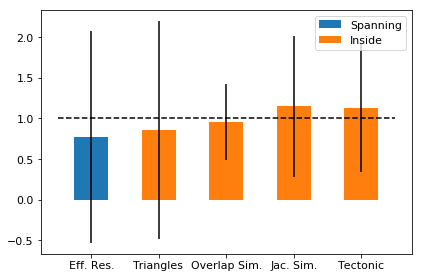

Effective Resistance -- t-test
t-statistic:-31.1608405881, p-value:6.64663104643e-212
Triangle Participation -- t-test
t-statistic:24.4360382777, p-value:1.70789328356e-131
Minimum Degree -- t-test
t-statistic:20.0553790571, p-value:2.7573802906e-89
Jaccard Similarity -- t-test
t-statistic:-38.765643108, p-value:0.0
Tectonic -- t-test
t-statistic:-38.5219649967, p-value:0.0


In [13]:
# # # # # # # # # # # # # # 
# border edge statistics  #
# # # # # # # # # # # # # # 

plt.rcParams.update({'font.size': 11})
for n_t in n_type:
    #if n_t != 'snap':# and n_t != 'partition':
    #    continue
    for param in type_params[n_t]:
        print(" *** ")
        G = Graph()
        G.loadNetwork( param[0] )
        G.setEdgeIndex()
        print(" Calculate effective resistance ")
        start = time.time()
        G.calculateResistance()
        print("Time Elapsed: {:.2f} sec".format(time.time()-start))
        #print(" Calculate core number ")
        #G.calculateCoreNumber()
        print(" Get triangle participation ")
        start = time.time()
        G.calculateTriangleParticipation()
        print("Time Elapsed: {:.2f} sec".format(time.time()-start))
        print(" Get Jaccard Similarity ")
        G.calculateJaccardSimilarity()
        print(" Calculate Tectonic ")
        G.calculateTectonic()
        print(" Calculate Minimum Degree")
        G.calculateMinDegree()
        if G.name in ['amazon','youtube','dblp']:
            P = G.readCommunitiesSNAP()
        elif G.name in ['PPI', 'Wikipedia','BlogCatalog', 'Flickr']:
            P = G.readMatlabCommunities()
        else:
            P = G.graphPartitioning(20)
        
        G.borderEdgesStatistics()
        G.borderEdges_ttest()

In [ ]:
# # # # # # # # # # # # # #
#    SPECTRAL     # #  V  #
#  SPARSIFICATION # #  1  #
# # # # # # # # # # # # # #
plt.rcParams.update({'font.size': 18})

n_type = ['snap', 'learning-literature']
type_params = {
    'learning-literature': [['BlogCatalog.mat'],['PPI.mat'],['Wikipedia.mat']],
    'snap': [['Facebook.txt'],['ca-GrQc.txt']]}
#type_params = {'learning-literature': [['BlogCatalog.mat']]}

for n_t in n_type:
    for param in type_params[n_t]:
        print(" *** ")
        G = Graph()
        G.loadNetwork( param[0] )
        print(" Calculate effective resistance ")
        G.calculateResistance()
        print(" Calculate Triangle Partication ")
        G.calculateTriangleParticipation()
        ETP = G.getTriangleParticipation( )
        print(" Calculate Jaccard Similarity ")
        G.calculateJaccardSimilarity()
        print(" Calculate Tectonic ")
        G.calculateTectonic()
        print(" Calculate Minimum Degree ")
        G.calculateMinDegree()
        
        # - Metrics - #
        #1. Effective Resistance
        ER = np.array( G.getEffectiveResistances() )
        ER_sort = (-ER).argsort() # desceding sort
        #2.  2/(2 + t(i,j)) Inverse Triangles
        IT = np.array([2/(2+ETP[i]) for i in range(len(ETP))])
        IT_sort = (-IT).argsort()
        #3. Jaccard Similarity - Ascending
        JS = np.array(G.getJaccardSimilarity())
        JS_sort = JS.argsort()
        #4. Overlap Similarity - Ascending
        MD = G.getMinDegree()
        OVLP = [ETP[i]/MD[i] for i in range(len(MD))]
        OVLP = np.array(OVLP)
        MD_sort = OVLP.argsort()
        #5. Tectonic - Ascending
        TEC = np.array( G.getTectonic() )
        TEC_sort = TEC.argsort()
        #6. Random ordering - Baseline
        RND_sort = np.arange(G.m)
        np.random.shuffle( RND_sort )
        # Initialize L_G, P, eigenvalues
        L,P = G.returnLalpacianAndP()
        eigenvalues,_ = eig(P * L * P)
        #eigenvalues = np.sort(eigenvalues)
        
        # init stats -- 
        ER_error = []
        IT_error = []
        JS_error = []
        MD_error = []
        TEC_error = []
        RND_error = []
        
        for fraction in [0.01,0.05,0.10,0.25,0.5,0.75]:
            print( fraction )
            number_of_edges = int( fraction*G.m )
            
            # Effective Resistance
            Lh = G.returnSubgraphLaplacian( ER_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            ER_error.append(error)
            
            # Inverse Triangles
            Lh = G.returnSubgraphLaplacian( IT_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            IT_error.append(error)
            
            # Jaccard Similarity
            Lh = G.returnSubgraphLaplacian( JS_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            JS_error.append(error)
            
            #Minimum Degree
            Lh = G.returnSubgraphLaplacian( MD_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            MD_error.append(error)
            
            # Tectonic
            Lh = G.returnSubgraphLaplacian( TEC_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            TEC_error.append(error)
            
            # Random
            Lh = G.returnSubgraphLaplacian( RND_sort[:number_of_edges] )
            eigenvalues_h,_ = eig(P * Lh * P)
            #eigenvalues_h = np.sort(eigenvalues_h)
            error = rmse( np.real(eigenvalues), np.real(eigenvalues_h))
            RND_error.append(error)
         
        x = [0.01,0.05,0.10,0.25,0.5,0.75,1]
        plt.plot( x, ER_error+[0], marker='o', markerfacecolor='black', markersize=12, color='grey', linewidth=4, linestyle='solid', label="Eff. Res")
        plt.plot( x, IT_error+[0], marker='x', markerfacecolor='red', markersize=12, color='orangered', linewidth=4, linestyle='dashed', label="Triangles")
        plt.plot( x, JS_error+[0], marker='s', markerfacecolor='green', markersize=12, color='mediumseagreen', linewidth=4, linestyle='dotted', label="Jac. Sim.")
        plt.plot( x, MD_error+[0], marker='^', markerfacecolor='gold', markersize=12, color='khaki', linewidth=4,linestyle='dashdot', label="Overlap Sim.")
        plt.plot( x, TEC_error+[0], marker='v', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,linestyle='solid', label="TECTONIC")
        plt.plot( x, RND_error+[0], marker='+', markerfacecolor='silver', markersize=12, color='gainsboro', linewidth=4,linestyle='dashed', label="Random")
        plt.legend(loc='lower left', prop={'size': 12})
        plt.xlabel('Fraction of Edges')
        plt.ylabel('RMSE') 
        plt.title( G.name )
        #plt.savefig('edgeSorting/'+param[0].split('.txt')[0]+'NOOVS.eps', format='eps', bbox_inches='tight')
        plt.show()